# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

D = np.loadtxt('data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]
eps = 1e-12
X = (X - X.mean(axis=0))/(X.std(axis = 0) + eps)
Y = Y.reshape((-1,1))
# X = np.hstack((torch.ones(X.shape[0], 1), X))
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self,in_features):
        super(LinearModel,self).__init__()
        self.fc = torch.nn.Linear(in_features,1,bias=True)
        
    def forward(self,x):
        x = self.fc(x)
        return x

In [8]:
def train_model(model,criterion, optimizer, X_train, y_train, X_val=None, y_val=None, batch_size = 16, epochs = 500, verbose = True):
    history, val_history = [], []
    for epoch in range(1, epochs + 1):
        fraction = X_train.shape[0] // batch_size
        batch_range = range(fraction)
        for i in batch_range:
            x_batch = X_train[i * batch_size: (i + 1) * batch_size]
            y_batch = y_train[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(y_batch, predictions)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        with torch.no_grad():
            history.append(loss.item())
            if (X_val is not None) or (y_val is not None):
                val_predictions = model(X_val)
                val_history.append(criterion(val_predictions, y_val).item())
        if verbose:
            output = f'epoch {epoch}: {history[-1]}' if (X_val is None) or (y_val is None) else f'epoch {epoch}: {loss.item()}; val loss: {val_history[-1]}'
            print(output)
    return history, val_history

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования.

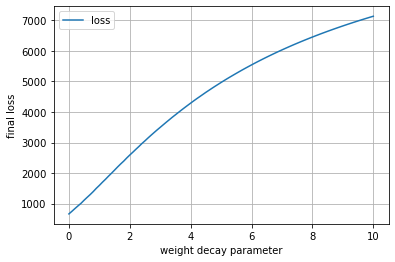

In [18]:
param_range = np.arange(0.0, 10.1, 0.1)
loss_list = []
for alpha in param_range:
    model = LinearModel(X.shape[1])
    mse_loss = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(),lr = 1e-4, weight_decay= alpha)

    history, val_history = train_model(model, mse_loss, optimizer, X, Y,
        epochs = 100,
        batch_size = 16,
        verbose = False)
    model.eval()
    prediction = model(X)
    loss = mse_loss(prediction, Y)
    loss_list.append(loss.item())

plt.plot(param_range, loss_list, label = 'loss')
plt.xlabel("weight decay parameter")
plt.ylabel("final loss")
plt.legend() 
plt.grid()
plt.show()

2. Подготовьте исходные данные для 5 fold CV.

In [19]:
def k_fold_training(X, y, k, epochs, lr, weight_decay_param, batch_size = 16, verbose = True):
    num_val_samples = len(X) // k
    
    models = []
    history_list = []
    train_scores = []
    val_scores = []
    
    for i in range(k):
        if verbose:
            print('processing fold #', i +1)
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = torch.Tensor(np.concatenate( [X[:i * num_val_samples],
        X[(i + 1) * num_val_samples:]],
        axis=0))
        partial_train_targets = torch.Tensor(np.concatenate(
        [y[:i * num_val_samples],
        y[(i + 1) * num_val_samples:]], axis=0))
        model = LinearModel(X.shape[1])
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay_param)
        if verbose:
            print(f'Training {i+1} model')
        history = train_model(model, criterion, optimizer, partial_train_data, partial_train_targets, val_data, val_targets,
                               batch_size = batch_size,
                              epochs = epochs,
                             verbose = False)
        with torch.no_grad():
            val_score = criterion(model(val_data), val_targets)
            train_score = criterion(model(partial_train_data), partial_train_targets)
        if verbose:
            print(f'val_score: {val_score}')
        
        models.append(model)
        train_scores.append(train_score)
        val_scores.append(val_score)        
        history_list.append(history)
    
    return {'models': models, 'history': history_list, 'train_scores': train_scores, 'val_scores': val_scores}
    

In [20]:
info = k_fold_training(X,Y, 5, 50, 0.1, weight_decay_param=0.1)

processing fold # 1
Training 1 model
val_score: 111.44230651855469
processing fold # 2
Training 2 model
val_score: 112.59628295898438
processing fold # 3
Training 3 model
val_score: 135.98614501953125
processing fold # 4
Training 4 model
val_score: 123.69572448730469
processing fold # 5
Training 5 model
val_score: 135.38836669921875


3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.

In [21]:
def random_search(X, y , steps, lr, weight_decay_param, verbose = True, epochs = 100,batch_size = 16):
    mean_scores = []
    params_list = []
    for i in range(1, steps+1):
        random_lr = np.random.uniform(*lr)
        random_weigh_decay = np.random.uniform(*weight_decay_param)
        params = {'lr': random_lr, 'weight_decay': random_weigh_decay}
        if verbose:
            print(f'{i}) random_lr: {random_lr}; random_weight_decay: {random_weigh_decay}')
        
        info = k_fold_training(X, y, 5, epochs, random_lr, random_weigh_decay, batch_size = batch_size, verbose = False)
        mean_score = np.array(info['val_scores']).mean()
        if verbose:
            print(f'mean score: {mean_score}\n')
        mean_scores.append(mean_score)
        params_list.append(params)
    
    min_index = np.array(mean_scores).argmin()
    if verbose:
        print(f'optimal params: {params_list[min_index]}; mean score: {mean_scores[min_index]}')
    return params_list[min_index]
        

In [22]:
params_list = random_search(X, Y, 100, [1e-5, 1e-1], [0.0, 1.0])

1) random_lr: 0.06537590137890327; random_weight_decay: 0.5150931213986079
mean score: 436.7479553222656

2) random_lr: 0.0010037599524934406; random_weight_decay: 0.4726027922989757
mean score: 395.7762756347656

3) random_lr: 0.044637492883860985; random_weight_decay: 0.44903745734241296
mean score: 358.7312316894531

4) random_lr: 0.0034200727307234415; random_weight_decay: 0.008329299803420787
mean score: 102.7076187133789

5) random_lr: 0.03804154176742466; random_weight_decay: 0.041276593712427645
mean score: 105.69969177246094

6) random_lr: 0.02587066797941266; random_weight_decay: 0.0387456015509845
mean score: 105.16496276855469

7) random_lr: 0.08927501019996932; random_weight_decay: 0.6593788256298732
mean score: 637.5734252929688

8) random_lr: 0.023672982993593435; random_weight_decay: 0.07257520793020755
mean score: 111.81888580322266

9) random_lr: 0.03749530601890152; random_weight_decay: 0.8625056539157973
mean score: 808.84375

10) random_lr: 0.01379662107632512; ran

mean score: 712.0662231445312

78) random_lr: 0.029979570770027223; random_weight_decay: 0.8755096248247721
mean score: 823.2609252929688

79) random_lr: 0.04968662524520889; random_weight_decay: 0.22026944703986562
mean score: 177.21705627441406

80) random_lr: 0.016611650480199955; random_weight_decay: 0.26909694055740185
mean score: 209.85336303710938

81) random_lr: 0.08824228869389265; random_weight_decay: 0.4386536692744688
mean score: 377.48468017578125

82) random_lr: 0.05973785153133901; random_weight_decay: 0.3613232493281575
mean score: 284.4822692871094

83) random_lr: 0.06591530861116066; random_weight_decay: 0.9193792772315571
mean score: 922.23876953125

84) random_lr: 0.04841736693767604; random_weight_decay: 0.27224763784808526
mean score: 211.38345336914062

85) random_lr: 0.04085083495549791; random_weight_decay: 0.08785185291250253
mean score: 116.0931167602539

86) random_lr: 0.05403560631117872; random_weight_decay: 0.27685620182188186
mean score: 215.642730712890

4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [24]:
model = LinearModel(X.shape[1])
mse_loss = torch.nn.MSELoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4,
# #                             momentum = 0.97,
# #                             nesterov=True,
#                             weight_decay=1)
optimizer = torch.optim.SGD(model.parameters(), **params_list)

history, val_history = train_model(model, mse_loss, optimizer, X[200:], Y[200:],
        X[:200], Y[:200],
        epochs = 100,
        batch_size = 16,
        verbose = True)

epoch 1: 2900.9853515625; val loss: 4768.97900390625
epoch 2: 1270.203125; val loss: 2117.0966796875
epoch 3: 595.0693969726562; val loss: 1033.177001953125
epoch 4: 297.0303649902344; val loss: 550.32568359375
epoch 5: 162.91407775878906; val loss: 322.1912536621094
epoch 6: 103.65330505371094; val loss: 210.2359619140625
epoch 7: 78.96755981445312; val loss: 153.89273071289062
epoch 8: 69.9816665649414; val loss: 124.9963607788086
epoch 9: 67.80599975585938; val loss: 109.9269790649414
epoch 10: 68.31970977783203; val loss: 101.9319839477539
epoch 11: 69.68145751953125; val loss: 97.60795593261719
epoch 12: 71.12311553955078; val loss: 95.21725463867188
epoch 13: 72.36679077148438; val loss: 93.86153411865234
epoch 14: 73.34740447998047; val loss: 93.07086181640625
epoch 15: 74.08355712890625; val loss: 92.59573364257812
epoch 16: 74.61959075927734; val loss: 92.30127716064453
epoch 17: 75.00212097167969; val loss: 92.11323547363281
epoch 18: 75.27106475830078; val loss: 91.989707946

91.42268371582031


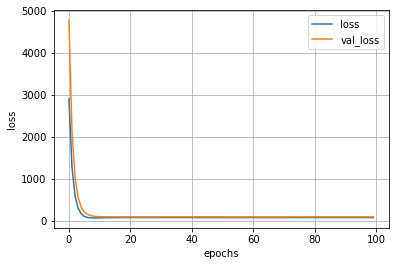

In [25]:
print(val_history[-1])
plt.plot(range(len(history)), history, label = 'loss')
plt.plot(range(len(val_history)), val_history, label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend() 
plt.grid()
plt.show()